# Ingreduce : Recommender System

For our project, we would suggest the most relevant recipes for and to our users. Many approaches are possible. Here, we will recommend recipes based on their text features, such as the recipe name and description, ingredients used, and instructions. The idea is that, if a user likes one recipe, similar recipes in terms of how they are described, made and prepared should be liked too.

First, we need to import the data used for the algorithm. Since we didn't collect all recipe information as planned, we need to select the data that is relevant to us.

In [1]:
import pickle
import pandas as pd

filename = 'df4840'
infile = open(filename,'rb')
recipe_df = pickle.load(infile)

# Dropping rows with nan values
recipe_df.drop(recipe_df.index[2148], inplace=True)

# Selecting rows with recipe info
recipe_df = recipe_df.loc[:4840]

## Recsys 1

Below is a first recommendation system that I have tried out. As we can see, the results are quite mixed. 

Note that the code sample comes from [Aditya Sharma on datacamp.com](https://www.datacamp.com/tutorial/recommender-systems-python).

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

recipe_df['all_text'] = recipe_df['name'] + ' ' + recipe_df['ingredients'] + ' ' + recipe_df['instructions'] + ' '


#Define a TF-IDF Vectorizer Object. Remove all english stop words.
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(recipe_df['all_text'].loc[:4840])

tfidf_matrix.shape

tfidf.get_feature_names()

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse map of indices and recipe names
indices = pd.Series(recipe_df.index, index=recipe_df['name'])

# Function that takes in recipe name as input and outputs most similar recipes
def get_recommendations(name, cosine_sim=cosine_sim):
    # Get the index of the recipe that matches the name
    idx = indices[name]

    # Get the pairwsie similarity scores of all recipes with that recipe
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the recipes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar recipes
    sim_scores = sim_scores[1:11]

    # Get the recipe indices
    recipe_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar recipes
    return recipe_df['name'].iloc[recipe_indices]

### Recsys 1 results

In [3]:
get_recommendations('Pork Enchiladas Recipe')

41                  Easter Deviled Eggs Recipe
3520                  Watermelon Cookie Recipe
2720                      Hot Onion Dip Recipe
4093    Coconut Cherry Surprise Cookies Recipe
850                            Chip Dip Recipe
4005                       Cheese Dip I Recipe
1864              Fresh Strawberry Marble Cake
3493        Strawberry Compote Cupcakes Recipe
2133          Spooky Halloween Eyeballs Recipe
4015              Red Velvet Cheesecake Recipe
Name: name, dtype: object

This pork enchiladas recipe returns recommendation that are quite random. The cakes are recommended because of the pork enchiladas recipe is prepared in the oven. So, the preparations are similar but not the recipes' styles.

In [4]:
get_recommendations('Zippy Tuna Recipe')

3131                Simple Tuna Melt Recipe
1781                Canned Tuna Loaf Recipe
211     Old Fashioned Macaroni Salad Recipe
971           Avocado and Tuna Tapas Recipe
1512               Mediterranean Tuna Bites
1518           Tuna Curry in a Hurry Recipe
131           Tuna and Avocado Salad Recipe
1702          Greek-Style Tuna Salad Recipe
420         Indian-Spiced Baked Fish Recipe
3546            Easy White BBQ Sauce Recipe
Name: name, dtype: object

Here, we're mostly given tuna recipes after telling the algorithm that we want more recipes like the 'zippy tuna recipe'. This is not a miss but a little too similar.

In [5]:
get_recommendations('Homemade Wonton Soup')

3533                                Yaki Mandu Recipe
910                                Egg Roll in a Bowl
201                      Chinese Egg Dumplings Recipe
4770                   Spicy Bok Choy in Garlic Sauce
319                            Rhubarb Wontons Recipe
1017                     Chicken and Snow Peas Recipe
4825                 Asian-Style Shrimp Scampi Recipe
1059                    Mushroom Bok Choy Soup Recipe
1537    Easy Homemade Beef and Ricotta Ravioli Recipe
761                         Quick Noodle-Veggie Bowls
Name: name, dtype: object

Here, we get a lot of Asian cuisine recipes after telling the algorithm that we want more recipes like an Asian cuisine recipe. This makes sense, right?

## Recsys 2

Below we use the classical Latent Dirichlet allocation algorithm.

The following code is largely inspired by code samples from [Radim Řehůřek](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html), [Nicha Ruchirawat](https://nicharuc.github.io/topic_modeling/), [Monkeylearn](https://monkeylearn.com/blog/text-cleaning/), [Rachel Zhiqing Zheng](https://github.com/ZeeTsing/Recipe_reco) and [Palisand on stackoverflow.com](https://stackoverflow.com/questions/22433884/python-gensim-how-to-calculate-document-similarity-using-the-lda-model).

### Pre-process and vectorize the documents

#### Selecting and cleaning the data

In [6]:
# Selecting the text features of the ML algorithm
df = recipe_df[['name', 'description', 'ingredients', 'instructions']]

# Creating a list of documents, where each document is a string containing info for one recipe
values_tolist = df.values.tolist()
docs = []

for i in range(len(values_tolist)):
    joined = ' '.join(values_tolist[i])
    docs.append(joined)

In [7]:
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')

cleaned_docs = []

for text in docs:
    
    # Normalizing text
    text = text.lower()
    
    # Removing Unicode Characters
    text = re.sub(r'(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?', '', text)
    
    # Removing stopwords
    text = ' '.join([word for word in text.split() if word not in (stop)])
        
    cleaned_docs.append(text)

In [8]:
# Renaming to docs
docs = cleaned_docs

#### Tokenizing the text

In [9]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

#### Lemmatizing the tokens

In [10]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

#### Computing bigrams

In [11]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [12]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

#### Computing a bag-of-words representation of the data

In [13]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [14]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2224
Number of documents: 4840


### Training and Model selection

Now that we have preprocessed the data for the LDA algorithm, we can train the model. There are many parameters that we can tune. We'll maximize coherence, which has shown to lead to better human interpretability, by optimizing a measure called *Cv*.

In [15]:
# Train LDA model.
from gensim.models import LdaModel
import gensim

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

# We'll have a look at coherence when the number of topics ranges from 5 to 45.
coherence = []
for k in range(5,45):
    print('Round: '+str(k))
    ldamodel = LdaModel(
                        corpus=corpus,
                        id2word=id2word,
                        chunksize=5000,
                        alpha='auto',
                        eta='auto',
                        iterations=200,
                        num_topics=k,
                        passes=40,
                        eval_every=None
                    ) 
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=docs,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Round: 30
Round: 31
Round: 32
Round: 33
Round: 34
Round: 35
Round: 36
Round: 37
Round: 38
Round: 39
Round: 40
Round: 41
Round: 42
Round: 43
Round: 44


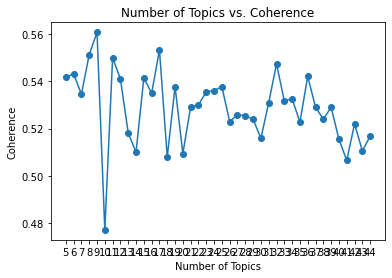

In [16]:
import matplotlib.pyplot as plt

x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

Cv varies a lot but mostly has a download trend. Here is a closer look at the first part of the data.

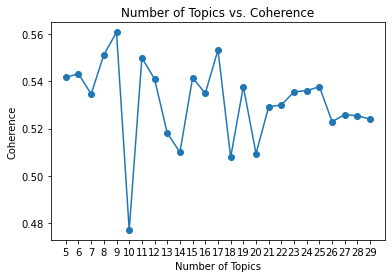

In [19]:
import matplotlib.pyplot as plt

x_val = [x[0] for x in coherence[:25]]
y_val = [x[1] for x in coherence[:25]]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

Since the highest coherence is not always where the highest Cv is, let's try a couple of number of topics values to see which has the best result. We'll try 9, 11, 15 and 17.

In [20]:
ldamodel9 = LdaModel(
                        corpus=corpus,
                        id2word=id2word,
                        chunksize=5000,
                        alpha='auto',
                        eta='auto',
                        iterations=200,
                        num_topics=9,
                        passes=40,
                        eval_every=None,
                        random_state = 0
                    )

In [31]:
ldamodel11 = LdaModel(
                        corpus=corpus,
                        id2word=id2word,
                        chunksize=5000,
                        alpha='auto',
                        eta='auto',
                        iterations=200,
                        num_topics=11,
                        passes=40,
                        eval_every=None,
                        random_state = 0
                    )

In [33]:
ldamodel15 = LdaModel(
                        corpus=corpus,
                        id2word=id2word,
                        chunksize=5000,
                        alpha='auto',
                        eta='auto',
                        iterations=200,
                        num_topics=15,
                        passes=40,
                        eval_every=None,
                        random_state = 0
                    )

In [22]:
ldamodel17 = LdaModel(
                        corpus=corpus,
                        id2word=id2word,
                        chunksize=5000,
                        alpha='auto',
                        eta='auto',
                        iterations=200,
                        num_topics=17,
                        passes=40,
                        eval_every=None,
                        random_state = 0
                    ) 

In [24]:
ldamodel9.show_topics(9, num_words=10, formatted=False)

[(0,
  [('potato', 0.03129277),
   ('degree', 0.027545372),
   ('oven', 0.026101017),
   ('place', 0.016631544),
   ('slice', 0.015628982),
   ('bacon', 0.014318483),
   ('degree_degree', 0.013362534),
   ('baking', 0.011229317),
   ('apple', 0.011211334),
   ('preheat', 0.011034688)]),
 (1,
  [('cake', 0.024057709),
   ('sugar', 0.023995342),
   ('cream', 0.023508033),
   ('ounce', 0.019928945),
   ('juice', 0.019595915),
   ('lemon', 0.016672458),
   ('orange', 0.013066511),
   ('ice', 0.011868275),
   ('white', 0.011354121),
   ('pour', 0.010701891)]),
 (2,
  [('water', 0.035078168),
   ('boil', 0.023034325),
   ('bring', 0.019783657),
   ('pasta', 0.014640049),
   ('remove', 0.014633953),
   ('jar', 0.014325855),
   ('chop', 0.013097886),
   ('place', 0.011725674),
   ('pot', 0.009583983),
   ('sugar', 0.009239415)]),
 (3,
  [('chicken', 0.03216159),
   ('pepper', 0.024723856),
   ('oil', 0.017710544),
   ('garlic', 0.01711224),
   ('olive', 0.0134606585),
   ('olive_oil', 0.011496

In [32]:
ldamodel11.show_topics(11, num_words=10, formatted=False)

[(0,
  [('oven', 0.033431962),
   ('degree', 0.02684928),
   ('potato', 0.026537016),
   ('bacon', 0.02075671),
   ('slice', 0.020524243),
   ('place', 0.017558947),
   ('apple', 0.014689921),
   ('baking', 0.014519233),
   ('degree_degree', 0.012973619),
   ('preheat', 0.012593399)]),
 (1,
  [('cake', 0.038122382),
   ('sugar', 0.02649655),
   ('pan', 0.019586949),
   ('egg', 0.017644325),
   ('flour', 0.015797757),
   ('butter', 0.01423525),
   ('white', 0.014138297),
   ('beat', 0.013763779),
   ('vanilla', 0.013183659),
   ('cream', 0.012823513)]),
 (2,
  [('juice', 0.026930742),
   ('water', 0.025429703),
   ('sugar', 0.023485005),
   ('lemon', 0.018110448),
   ('orange', 0.017963028),
   ('ice', 0.01675127),
   ('ounce', 0.015110671),
   ('pour', 0.012227857),
   ('fresh', 0.01144114),
   ('boil', 0.010951617)]),
 (3,
  [('pepper', 0.02998495),
   ('olive', 0.020488184),
   ('oil', 0.020480338),
   ('chopped', 0.016974865),
   ('olive_oil', 0.016319605),
   ('salad', 0.015992405)

In [34]:
ldamodel15.show_topics(15, num_words=10, formatted=False)

[(0,
  [('potato', 0.076295264),
   ('bacon', 0.04155561),
   ('apple', 0.038069367),
   ('sweet', 0.02263063),
   ('squash', 0.02058169),
   ('sweet_potato', 0.018087814),
   ('place', 0.014751249),
   ('peeled', 0.013825173),
   ('brown', 0.0124454005),
   ('cook', 0.0121126)]),
 (1,
  [('sugar', 0.03486046),
   ('cake', 0.023941152),
   ('pan', 0.018073099),
   ('white', 0.017443752),
   ('egg', 0.016533704),
   ('butter', 0.016274402),
   ('lemon', 0.015987786),
   ('cream', 0.0150247505),
   ('flour', 0.01431668),
   ('beat', 0.013668565)]),
 (2,
  [('water', 0.052930187),
   ('sugar', 0.033761144),
   ('boil', 0.024083052),
   ('bring', 0.02134807),
   ('saucepan', 0.020086566),
   ('remove', 0.017431611),
   ('white', 0.016091503),
   ('jar', 0.01371161),
   ('pour', 0.013111505),
   ('white_sugar', 0.012737659)]),
 (3,
  [('pepper', 0.027975816),
   ('chopped', 0.017386662),
   ('olive', 0.01705761),
   ('salad', 0.016588671),
   ('oil', 0.016381118),
   ('garlic', 0.013864786)

In [25]:
ldamodel17.show_topics(17, num_words=10, formatted=False)

[(0,
  [('potato', 0.09778925),
   ('bacon', 0.051181525),
   ('squash', 0.026121514),
   ('sweet', 0.025987864),
   ('sweet_potato', 0.022979798),
   ('place', 0.016328229),
   ('slice', 0.015636126),
   ('pear', 0.010645356),
   ('peeled', 0.010500321),
   ('skillet', 0.0104251355)]),
 (1,
  [('juice', 0.063789755),
   ('lemon', 0.057467896),
   ('orange', 0.031466864),
   ('lemon_juice', 0.027246924),
   ('sugar', 0.023571288),
   ('lime', 0.023500718),
   ('ounce', 0.023256646),
   ('pineapple', 0.02073169),
   ('zest', 0.019491045),
   ('fluid', 0.01449449)]),
 (2,
  [('water', 0.032064386),
   ('strawberry', 0.024092937),
   ('ice', 0.022633322),
   ('jar', 0.020724816),
   ('sugar', 0.018273741),
   ('banana', 0.015103798),
   ('cream', 0.014147406),
   ('peach', 0.013600479),
   ('ice_cream', 0.013470908),
   ('pour', 0.012778645)]),
 (3,
  [('pepper', 0.031186292),
   ('olive', 0.020422487),
   ('oil', 0.018797986),
   ('chopped', 0.018587133),
   ('garlic', 0.016588898),
   (

11 topics yielded the best results: we could clearly imagine the type of dish (or drinks) as well as the type of cuisine of each topic while being sufficiently cohesive, so we'll go with this.

### Finding recommendations

In [46]:
lda = ldamodel11

In [50]:
from gensim import models, similarities

def calculate_similarity(query, lda, corpus, dct):
    
    # cosine similarity
    index = similarities.MatrixSimilarity(lda[corpus])
    
    query_doc = query.lower().split()
    
    vec_bow = dct.doc2bow(query_doc)
    vec_lda = lda[vec_bow]
    sims = index[vec_lda]
    
    #calculate rank
    sim_rank = sorted(enumerate(sims), key=lambda item: -item[1])
    
    return sim_rank

def calculate_recommendation(sim_rank,groups,n_reco = 10):
    results = [sim_rank[0][0]]
    results_prob = [sim_rank[0][1]]
    result_group = [sim_rank[0][1]]
        
    for recipe,group in zip(sim_rank[1:],groups[1:]):
        if group not in set(result_group):
            results.append(recipe[0])
            result_group.append(group)
            results_prob.append(recipe[1])
        if len(results) == n_reco:
            break
    print(result_group,"\n",results_prob)
    return results

def get_similarity_reco(query, ldamodel, dct, corpus, n_reco = 10):
    
    #calculate rank
    sim_rank = calculate_similarity(query, lda, corpus, dct)
    
    #find groups according to lda model
    groups = []
    for l in ldamodel[corpus]:
        try:
            groups.append(l[0][0])
        except:
            groups.append(random.randint(1, 100))
            
    return calculate_recommendation(sim_rank,groups,n_reco)

def print_reco(results):
    return recipe_df.iloc[results]

### Recsys 2 results

In [51]:
query1 = 'Pork Enchiladas Recipe'
query2 = 'Zippy Tuna Recipe'
query3 = 'Homemade Wonton Soup'

In [52]:
results = get_similarity_reco(query3, lda, gensim_dict, corpus, n_reco = 10)
print_reco(results)

[0.9975672, 2, 4, 0, 1, 3, 8, 6, 5, 7] 
 [0.9975672, 0.9975564, 0.9975151, 0.99741757, 0.99741757, 0.99741757, 0.99741757, 0.99741757, 0.9971726, 0.9948253]


,recipe_link,name,description,prep,cook,additional,total,servings,yield,ingredients,instructions,nutrition,images_url,all_text
1910,https://www.allrecipes.com/recipe/138925/shiit...,Shiitake and Baby Bella Mushroom Risotto Recipe,This risotto is extremely good. I like using f...,25 mins,35 mins,None,1 hr,6,6 servings,"1 tablespoon olive oil; ½ shallot, minced; 4 o...",Heat olive oil in a large saucepan over medium...,439 calories; protein 9.7g; carbohydrates 60.7...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Shiitake and Baby Bella Mushroom Risotto Recip...
4626,https://www.allrecipes.com/recipe/15044/spruce...,Spruced Up Mashed Potatoes Recipe,"This recipe includes cauliflower, garlic and a...",None,None,None,None,10,10 servings,"5 pounds potatoes, peeled and quartered; 3 cup...",Bring a large pot of salted water to a boil. A...,222 calories; protein 5.8g; carbohydrates 43g;...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Spruced Up Mashed Potatoes Recipe 5 pounds pot...
3632,https://www.allrecipes.com/recipe/276169/savor...,"Savory, Zesty Cream of Potato Soup Recipe",This recipe is derived from my grandmother's p...,20 mins,1 hr,None,1 hr 20 mins,8,8 servings,"4 cups peeled, cubed russet potatoes; ½ pound ...",Place potatoes in a bowl of cold water and set...,458 calories; protein 10.9g; carbohydrates 21....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,"Savory, Zesty Cream of Potato Soup Recipe 4 cu..."
508,https://www.allrecipes.com/recipe/46028/herbed...,Herbed Mushrooms with White Wine Recipe,Mushrooms are sauteed with your favorite herbs...,10 mins,15 mins,None,25 mins,6,6 servings,1 tablespoon olive oil; 1 ½ pounds fresh mushr...,Heat the oil in a skillet over medium heat. Pl...,57 calories; protein 2.3g; carbohydrates 5.6g;...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Herbed Mushrooms with White Wine Recipe 1 tabl...
735,https://www.allrecipes.com/recipe/222875/gramm...,Gramma's Summa Borscht Recipe,My Gram is my biggest inspiration in both cook...,20 mins,4 hrs 40 mins,20 mins,5 hrs 20 mins,20,20 servings,1 bone-in picnic ham; 14 cups water; 1 white o...,Bring the water to a boil in a large stockpot....,455 calories; protein 34.8g; carbohydrates 27g...,None,Gramma's Summa Borscht Recipe 1 bone-in picnic...
1022,https://www.allrecipes.com/recipe/211123/cream...,Cream of Chicken Soup From Scratch Recipe,"I stopped using canned foods, so this is my al...",10 mins,10 mins,None,20 mins,4,4 cups,"1 ½ cups chicken stock, divided; 1 teaspoon fi...",Place 1 tablespoon of chicken stock in a sauce...,134 calories; protein 5.6g; carbohydrates 22.9...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Cream of Chicken Soup From Scratch Recipe 1 ½ ...
1314,https://www.allrecipes.com/recipe/68978/south-...,South Carolina She-Crab Soup Recipe,This she-crab soup is a staple for all of us l...,15 mins,45 mins,None,1 hr,8,None,5 tablespoons butter; 5 tablespoons all-purpos...,Melt butter in a large stockpot over medium he...,677 calories; protein 20.8g; carbohydrates 19....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,South Carolina She-Crab Soup Recipe 5 tablespo...
1744,https://www.allrecipes.com/recipe/12918/tuscan...,Tuscan Soup Recipe,"Tuscan soup with spicy sausages, potatoes, and...",20 mins,30 mins,None,50 mins,4,4 servings,"6 cups chicken broth; 1 onion, chopped; 3 (3.5...",Remove skin from sausage and crumble into fryi...,559 calories; protein 26.4g; carbohydrates 57....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Tuscan Soup Recipe 6 cups chicken broth; 1 oni...
4524,https://www.allrecipes.com/recipe/256102/pork-...,Pork Osso Buco,"Pork shank isn't as rich as veal, but I like i...",10 mins,3 hrs 10 mins,None,3 hrs 20 mins,6,6 servings,salt and freshly ground black pepper to taste;...,Salt and pepper both sides of pork shank secti...,262 calories; protein 30.3g; carbohydrates 9.7...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Pork Osso Buco salt and freshly ground black p...
1397,https:

In [53]:
results = get_similarity_reco(query1, lda, gensim_dict, corpus, n_reco = 10)
print_reco(results)

[0.9933618, 2, 4, 0, 1, 3, 8, 6, 5, 7] 
 [0.9933618, 0.9915169, 0.9913953, 0.9906501, 0.9905615, 0.9902851, 0.9899589, 0.9896913, 0.9887743, 0.98543274]


,recipe_link,name,description,prep,cook,additional,total,servings,yield,ingredients,instructions,nutrition,images_url,all_text
1278,https://www.allrecipes.com/recipe/168611/cola-...,Cola-Brined Chicken Wings Recipe,These easy wings make a great meal when paired...,10 mins,10 mins,2 hrs,2 hrs 20 mins,8,4 pounds of wings,½ cup kosher salt; 1 liter cola-flavored carbo...,Pour 1/2 cup kosher salt and the cola into a r...,339 calories; protein 16.6g; carbohydrates 10....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Cola-Brined Chicken Wings Recipe ½ cup kosher ...
466,https://www.allrecipes.com/recipe/275754/slow-...,Slow Cooker Shredded Beef Sandwiches Recipe,I like to serve these mouth-watering sandwiche...,15 mins,10 hrs,None,10 hrs 15 mins,16,16 sandwiches,1 (10.5 ounce) can condensed beef broth; 1 cup...,"Whisk beef broth, ketchup, brown sugar, lemon ...",601 calories; protein 41.2g; carbohydrates 80....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Slow Cooker Shredded Beef Sandwiches Recipe 1 ...
3089,https://www.allrecipes.com/recipe/236098/kay-k...,Kay Kay's Pulled Pork Recipe,This recipe is a hit with everybody! Great for...,20 mins,6 hrs,1 hr,7 hrs 20 mins,10,10 servings,3 tablespoons brown sugar; 1 tablespoon salt; ...,"Combine brown sugar, salt, paprika, black pepp...",339 calories; protein 18.8g; carbohydrates 26g...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Kay Kay's Pulled Pork Recipe 3 tablespoons bro...
2919,https://www.allrecipes.com/recipe/282320/grill...,Grilled Sweet and Sour Chicken Thighs,This is one of the best sweet and sour chicken...,10 mins,20 mins,3 hrs,3 hrs 30 mins,12,12 servings,1 cup pineapple juice; ½ cup soy sauce; ½ cup ...,"Mix pineapple juice, soy sauce, brown sugar, k...",265 calories; protein 26.5g; carbohydrates 14....,None,Grilled Sweet and Sour Chicken Thighs 1 cup pi...
1604,https://www.allrecipes.com/recipe/274973/grill...,Grilled Buffalo Chicken Thighs with Blue Chees...,All of the buffalo wing flavor you love in an ...,15 mins,15 mins,None,30 mins,6,6 servings,"3 stalks celery, cut into matchstick-size piec...","Combine celery, carrots, buttermilk, blue chee...",440 calories; protein 39.1g; carbohydrates 10....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Grilled Buffalo Chicken Thighs with Blue Chees...
2000,https://www.allrecipes.com/recipe/148853/smoky...,Smoky Steak Marinade Recipe,"This is a rich, smoky tasting marinade!",5 mins,None,None,5 mins,4,1 cup,½ cup Worcestershire sauce; ¼ cup liquid smoke...,"Whisk together Worcestershire sauce, liquid sm...",185 calories; protein 1.3g; carbohydrates 15.2...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Smoky Steak Marinade Recipe ½ cup Worcestershi...
1766,https://www.allrecipes.com/recipe/73947/shredd...,Shredded Beef Recipe,This is a delicious way to enjoy shredded beef...,20 mins,6 hrs,10 mins,6 hrs 30 mins,4,None,1 pound rump roast; 1 cup water; ¼ cup barbequ...,Place rump roast and water in a slow cooker. C...,215 calories; protein 19.8g; carbohydrates 15g...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Shredded Beef Recipe 1 pound rump roast; 1 cup...
2250,https://www.allrecipes.com/recipe/216773/slow-...,Slow Cooker Ribs Recipe,Super-simple recipe that will leave your mouth...,10 mins,8 hrs,None,8 hrs 10 mins,6,6 servings,"1 pinch steak seasoning, or to taste; 1 pinch ...","Mix the steak seasoning, garlic salt, black pe...",455 calories; protein 36.6g; carbohydrates 21....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Slow Cooker Ribs Recipe 1 pinch steak seasonin...
3032,https://www.allrecipes.com/recipe/218089/beer-...,Beer Brined Pork Chops Recipe,Tender full-flavored pork chops that are alway...,15 mins,15 mins,12 hrs,12 hrs 30 mins,8,8 pork chops,1 (12 ounce) can beer; 1 tablespoon red wine v...,"Whisk the beer, wine vinegar, corn syrup, must...",217 calories; protein 24.3g; carbohydrates 10g...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Beer Brined Pork Chops Recipe 1 (12 ounce) c

In [54]:
results = get_similarity_reco(query2, lda, gensim_dict, corpus, n_reco = 10)
print_reco(results)

[0.9917542, 2, 4, 0, 1, 3, 8, 6, 5, 7] 
 [0.9917542, 0.9917239, 0.9916734, 0.9916235, 0.99159646, 0.99131066, 0.9911538, 0.9909901, 0.9903009, 0.99012226]


,recipe_link,name,description,prep,cook,additional,total,servings,yield,ingredients,instructions,nutrition,images_url,all_text
2488,https://www.allrecipes.com/recipe/192677/busy-...,Busy Day Lunch Salad Recipe,"You can add capers, green olives, or extra hea...",15 mins,None,None,15 mins,2,2 servings,"1 (15 ounce) can garbanzo beans, drained and r...","Toss the garbanzo beans, tomato, onion, heart ...",341 calories; protein 13.9g; carbohydrates 38....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Busy Day Lunch Salad Recipe 1 (15 ounce) can g...
428,https://www.allrecipes.com/recipe/222574/like-...,Like No Other Pasta Salad Recipe,This is a unique and simple pasta salad recipe...,10 mins,10 mins,8 hrs,8 hrs 20 mins,12,12 servings,1 (16 ounce) package penne pasta; ½ large onio...,Bring a large pot of lightly salted water to a...,270 calories; protein 5.8g; carbohydrates 38.6...,None,Like No Other Pasta Salad Recipe 1 (16 ounce) ...
634,https://www.allrecipes.com/recipe/280984/stacy...,Stacy's Crunchy Tuna Salad,Why stick with just a traditional-style tuna s...,25 mins,None,None,25 mins,2,2 servings,"2 (5 ounce) cans albacore tuna in water, drain...","Place tuna in a medium bowl. Add tomato, shall...",517 calories; protein 35g; carbohydrates 12.6g...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Stacy's Crunchy Tuna Salad 2 (5 ounce) cans al...
95,https://www.allrecipes.com/recipe/240721/no-yo...,NO YOLKS® Saucy Shrimp Noodles with Feta,This simple yet elegant dish can be served wit...,20 mins,5 mins,None,25 mins,4,4 servings,½ (12 ounce) package NO YOLKS® Dumpling Noodle...,Prepare the noodles according to package direc...,391 calories; protein 19.8g; carbohydrates 54....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,NO YOLKS® Saucy Shrimp Noodles with Feta ½ (12...
3694,https://www.allrecipes.com/recipe/12754/seafoo...,Seafood And Cabbage Salad Recipe,This is a beautiful and delicious salad that w...,20 mins,None,None,20 mins,8,8 servings,2 ½ cups shredded cabbage; 1 cup shredded red ...,"In a small bowl, whisk together mayonnaise, le...",98 calories; protein 6.1g; carbohydrates 18.7g...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Seafood And Cabbage Salad Recipe 2 ½ cups shre...
2900,https://www.allrecipes.com/recipe/265525/edama...,Edamame Hummus with Garlic Scapes Recipe,Glorious garlic-and-edamame-flavored hummus. I...,10 mins,5 mins,10 mins,25 mins,24,3 cups,1 (16 ounce) package frozen shelled edamame (g...,Bring 6 cups of water to a boil in a saucepan....,111 calories; protein 3.1g; carbohydrates 5g; ...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Edamame Hummus with Garlic Scapes Recipe 1 (16...
2523,https://www.allrecipes.com/recipe/272391/jonis...,Joni's Leftover Turkey Salad Recipe,Add a slice of cheese and lettuce and enjoy th...,15 mins,None,1 hr,1 hr 15 mins,4,4 servings,"2 cups cooked turkey meat, chopped; ½ cup mayo...","Mix turkey, mayonnaise, sweet relish, Dijon mu...",387 calories; protein 22.2g; carbohydrates 10....,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Joni's Leftover Turkey Salad Recipe 2 cups coo...
1862,https://www.allrecipes.com/recipe/149816/emily...,Emily's Strawberry Balsamic Salad Recipe,"This sweet, tangy salad has lots of plate appe...",30 mins,None,None,30 mins,6,6 servings,¼ cup balsamic vinegar; 1 ½ tablespoons Dijon ...,"To make the dressing, place the balsamic vineg...",275 calories; protein 4.1g; carbohydrates 15.2...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Emily's Strawberry Balsamic Salad Recipe ¼ cup...
3846,https://www.allrecipes.com/recipe/229063/class...,Classic Restaurant Caesar Salad Recipe,I used to work at a very fancy restaurant whil...,20 mins,None,None,20 mins,2,2 servings,"2 cloves garlic, finely chopped; 3 anchovy fil...",Mash garlic with anchovies in a large salad bo...,362 calories; protein 8.4g; carbohydrates 9.5g...,https://imagesvc.meredithcorp.io/v3/mm/image?u...,Classic Restaurant Caesar Salad Recipe 2 clove...
1032,https://w

I'm honestly very satisfied with these recommendations. What do you think?

### Topic generated by the LDA

Below are the topics generated.

In [55]:
ldamodel.top_topics(corpus)

[([(0.061446894, 'cake'),
   (0.030959807, 'pan'),
   (0.023620443, 'sugar'),
   (0.023347236, 'egg'),
   (0.02215036, 'flour'),
   (0.01736049, 'degree'),
   (0.017106462, 'oven'),
   (0.017062837, 'butter'),
   (0.01688947, 'beat'),
   (0.015216741, 'white'),
   (0.014076171, 'batter'),
   (0.013974615, 'baking'),
   (0.013370022, 'extract'),
   (0.012161695, 'vanilla'),
   (0.011741601, 'cool'),
   (0.010132453, 'white_sugar'),
   (0.009519053, 'powder'),
   (0.009204243, 'mix'),
   (0.008815118, 'bake'),
   (0.008511923, 'vanilla_extract')],
  -0.7366000436667222),
 ([(0.056310236, 'pie'),
   (0.029103164, 'egg'),
   (0.028829485, 'crust'),
   (0.028195305, 'sugar'),
   (0.026230682, 'degree'),
   (0.022989616, 'oven'),
   (0.019047573, 'milk'),
   (0.016649444, 'cinnamon'),
   (0.016643465, 'butter'),
   (0.014668289, 'white'),
   (0.013663318, 'bake'),
   (0.012580924, 'pecan'),
   (0.012564243, 'degree_degree'),
   (0.011541208, 'white_sugar'),
   (0.011166237, 'vanilla'),
   (0